In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as torchvision_transforms
import numpy as np
import os
import pandas as pd
import math
import ntpath

from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

# from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
from myhelpers import config_plots
from HGNN.train import CNN, dataLoader

# config_plots.global_settings()

experimetnsFileName = "experiments.csv"

In [2]:
ShowActivations = False
Layername = 'layer4' #'network_fine.conv1' used for activations
Layername2 = 'fc' # 'self.g_y_fc' used for sorting the activation maps

ShowSmoothGrad = False 
UseGuidedBackprop = True

ShowCAM = True
CAM_type = "guidedGradCAM" #"ScoreCAM" #"guidedGradCAM" #"GradCAM" 
CAM_layer = "layer4"


classGenerate=True
GAPfeatureGenerate=True
useRegularization=True
L1_reg=True
layerName_GAP='gap_features'
GAP_output_index = slice(400, 401)
num_of_epochs = 8380
initial_learning_rate=9.546
wd= 0.0001269
useImage=False


In [3]:
# Model parameters
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
experimentName="Fish30-5run-PhyloNN6" #"Fish50_30-5run-BB-HGNN-crossvalidation" 
trial_hash="0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4" #PhyloNN
#"9d6646b1d44b3034255f21a9d658fffe2f80e4f2180745e169abeb72" #HGNN

# image file:
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_81913.jpg'
fileName= '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg'

# MISC
cuda=4
SEED_INT=-1

In [4]:
# set cuda
if cuda is not None:
    print("using cuda", cuda)
    torch.cuda.set_device(cuda)

using cuda 4


In [5]:
# Get experiment parameters
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
modelName = experimentRecord.iloc[0]["modelName"]
experimentPathAndName = os.path.join(experimentsPath, experimentName)
trialName = os.path.join(experimentPathAndName, modelName)
experiment_params = experimentRecord.to_dict('records')[0]
experiment_params = config_parser.fixExperimentParams(experiment_params)

if math.isnan(experiment_params['suffix']):
    experiment_params['suffix'] = None
print(experiment_params)

{'experimentName': 'Fish30-5run-PhyloNN6', 'modelName': 'models/0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'datasetName': 'datasplits/a30fade0855f8d4a9e28fdac4e65ae71ab21444a323ee6e3927d97f8', 'experimentHash': '2f4afd9af84811c61585f52e9e69fb2b8fc8e83ae71fa846e602b672', 'trialHash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'image_path': 'Curated4/Easy_30', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'PhyloNN', 'lambda': 1.0, 'unsupervisedOnTest': nan, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': False, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish30-5run-PhyloNN-smalldistances-intraKorthogonality', 'pretrained': True, 'epochs'

In [6]:
experimentPathAndName = os.path.join(experimentsPath, experimentName)
datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

In [7]:
datasetManager.updateParams(config_parser.fixPaths(experiment_params))

In [8]:
%%capture
train_loader, validation_loader, test_loader = datasetManager.getLoaders(SEED_INT)
# architecture = {
#     "fine": len(train_loader.dataset.csv_processor.getFineList()),
#     "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
# }
architecture = CNN.get_architecture(experiment_params, train_loader.dataset.csv_processor)
model = CNN.create_model(architecture, experiment_params, device=cuda)
CNN.loadModel(model, trialName, device=cuda)

In [9]:
def getTransformedImage(dataset, img, augmentation, normalization):
    augmentation2, normalization2, pad2 = dataset.toggle_image_loading(augmentation=augmentation, normalization=normalization)
    transforms = dataset.getTransforms()
    composedTransforms = torchvision_transforms.Compose(transforms)
    img_clone = composedTransforms(img)
#     print(img_clone.shape)
#     img_clone = img_clone.unsqueeze(0)
#     print(img_clone.shape)
    dataset.toggle_image_loading(augmentation2, normalization2, pad2)
    return img_clone


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

(-0.5, 447.5, 447.5, -0.5)

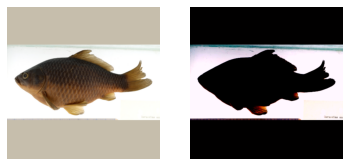

In [10]:
fig, axarr = plt.subplots(1, 2)


title = ntpath.basename(fileName)
original =  Image.open(fileName)
image_non_normalized = getTransformedImage(test_loader.dataset, original, False, False)
image_normalized = getTransformedImage(test_loader.dataset, original, False, True)

axarr[0].imshow(np.transpose(image_non_normalized.detach().numpy(), (1, 2, 0)))
axarr[1].imshow(np.transpose(image_normalized.detach().numpy(), (1, 2, 0)))
axarr[0].axis('off')
axarr[1].axis('off')

In [11]:
model.get_module(Layername).register_forward_hook(get_activation(Layername))
model.eval()
fc_params = model.get_module(Layername2).weight 
img = image_normalized.unsqueeze(0)
if cuda is not None:
    img = img.cuda()
output = model(img)
output_class = torch.argmax(output['fine'].squeeze())
im = transforms.ToPILImage()(image_non_normalized).convert("RGB")

In [12]:
import matplotlib.cm as mpl_color_map
import copy
from torchvision import transforms


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
#     print(activation, activation.shape)
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
#     print(heatmap.size, heatmap_on_image.size)
    heatmap = heatmap.resize(heatmap_on_image.size)
#     print(heatmap.size, heatmap_on_image.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

In [13]:
if ShowActivations:
    act = activation[Layername].squeeze()
    act_weights = fc_params[output_class,:].squeeze()
    act_weights_argsort = torch.argsort(act_weights, descending=True)

    act = act[act_weights_argsort]

    num_of_rows = math.ceil(act.size(0)/4)
    fig, axarr = plt.subplots(num_of_rows, 4, figsize=(12, 3*num_of_rows)) # 
    plt.tight_layout()

    # plt.rcParams["axes.titlesize"] = 8

    # fig, axarr = plt.subplots(8, 4, figsize=(4, 8))
    if cuda is not None:
        act_ = act.detach().cpu()
    i=0 
    for idx in trange(act.size(0)):
        _, overlapped = apply_colormap_on_image(im, act_[idx].detach().numpy(), 'seismic')
        axarr[idx//4, i].imshow(overlapped) # , cmap='gray'
        axarr[idx//4, i].axis('off')
        axarr[idx//4, i].set_title(format(act_weights[act_weights_argsort[idx]].item(), ".4f"), fontsize=15)
        i = i+1
        if i>3: i=0
    #     print(idx)    
    #     if idx==4: break 


In [14]:
# SmoothGrad (SaliencyMap)

from pytorchVisualizations import smooth_grad
from pytorchVisualizations.vanilla_backprop import VanillaBackprop
from pytorchVisualizations.guided_backprop import GuidedBackprop

if ShowSmoothGrad:
    BP = VanillaBackprop(model, cuda) if not UseGuidedBackprop else GuidedBackprop(model, cuda)

    param_n = 50
    param_sigma_multiplier = 4
    output = smooth_grad.generate_smooth_grad(BP,
                                       image_normalized.unsqueeze(0),
                                       output_class,
                                       param_n,
                                       param_sigma_multiplier)
    
#     color_map = mpl_color_map.get_cmap('seismic')
#     print(output.shape)
#     output = color_map(output.squeeze())
#     print(output.shape)
#     output = Image.fromarray((output*255).astype(np.uint8))
#     print(output.shape)
    output = np.abs(output)
    output = np.sum((output-output.min())*1.0/(output.max()-output.min()), axis=1)
#     print(output.shape)
    plt.imshow(output.squeeze(), cmap=plt.get_cmap('seismic')) # .transpose((1, 2, 0))

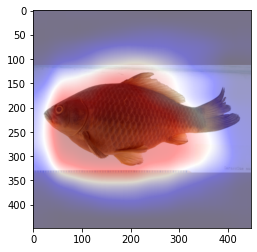

In [15]:
from pytorchVisualizations import gradcam, guided_gradcam, scorecam
from pytorchVisualizations.guided_backprop import GuidedBackprop

if ShowCAM:
    if CAM_type == "ScoreCAM":
        cam_generator = scorecam.ScoreCam(model, target_layer=CAM_layer, cuda=cuda)
    else:
        cam_generator = gradcam.GradCam(model, target_layer=CAM_layer, cuda=cuda)
    
    # Generate cam mask
    cam = cam_generator.generate_cam(image_normalized.unsqueeze(0), output_class)
    
    if CAM_type == "GuidedGradCAM":
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(image_normalized.unsqueeze(0), output_class)
        cam = guided_gradcam.guided_grad_cam(cam, guided_grads)
    
    _, overlapped = apply_colormap_on_image(im, cam, 'seismic')
    plt.imshow(overlapped) # , cmap='gray'

Iteration: 10 Loss 0.20
Iteration: 20 Loss -0.48
Iteration: 30 Loss -1.22
Iteration: 40 Loss -2.08
Iteration: 50 Loss -3.58
Iteration: 60 Loss -5.75
Iteration: 70 Loss -8.49
Iteration: 80 Loss -11.67
Iteration: 90 Loss -14.76
Iteration: 100 Loss -17.53
Iteration: 110 Loss -20.21
Iteration: 120 Loss -22.98
Iteration: 130 Loss -25.69
Iteration: 140 Loss -28.75
Iteration: 150 Loss -31.91
Iteration: 160 Loss -35.23
Iteration: 170 Loss -38.53
Iteration: 180 Loss -42.09
Iteration: 190 Loss -45.86
Iteration: 200 Loss -49.42
Iteration: 210 Loss -53.21
Iteration: 220 Loss -57.01
Iteration: 230 Loss -60.88
Iteration: 240 Loss -64.80
Iteration: 250 Loss -68.50
Iteration: 260 Loss -72.17
Iteration: 270 Loss -75.94
Iteration: 280 Loss -79.38
Iteration: 290 Loss -83.01
Iteration: 300 Loss -86.39
Iteration: 310 Loss -89.68
Iteration: 320 Loss -93.00
Iteration: 330 Loss -96.23
Iteration: 340 Loss -99.29
Iteration: 350 Loss -102.22
Iteration: 360 Loss -105.09
Iteration: 370 Loss -107.96
Iteration: 380 

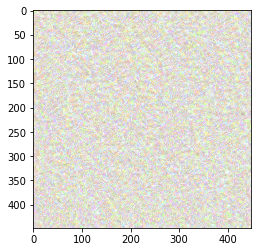

In [16]:
from pytorchVisualizations.generate_class_specific_samples import ClassSpecificImageGeneration
from pytorchVisualizations.generate_regularized_class_specific_samples import RegularizedClassSpecificImageGeneration
from PIL import Image

if classGenerate:
    img = image_non_normalized.unsqueeze(0) if useImage else None
    if not useRegularization:
        csig = ClassSpecificImageGeneration(model, output_class.item(), img, cuda=cuda, normalizer=test_loader.dataset.normalizer)
        im_generated, _  = csig.generate(iterations=num_of_epochs, initial_learning_rate=initial_learning_rate, verbose=True)
    else:
        csig = RegularizedClassSpecificImageGeneration(model, output_class.item(), img, cuda=cuda, normalizer=test_loader.dataset.normalizer)
        im_generated, _ = csig.generate(iterations=num_of_epochs, initial_learning_rate=initial_learning_rate, wd=wd, L1_reg=L1_reg, verbose=True)

    
    plt_img = im_generated.squeeze().permute(1,2,0).detach().numpy()
#     plt_img = (plt_img*255).astype(np.uint8)
#     plt_img = Image.fromarray(plt_img)
    plt.imshow(plt_img)
    
    print(output_class)
    im_generated_normalized = test_loader.dataset.normalizer(im_generated)
    print(torch.nn.Softmax()(model(im_generated_normalized.unsqueeze(0))['fine']))

In [17]:
if GAPfeatureGenerate:
    img = image_non_normalized.unsqueeze(0) if useImage else None
    if not useRegularization:
        csig = ClassSpecificImageGeneration(model, GAP_output_index, img, cuda=cuda, layer_name=layerName_GAP, normalizer=test_loader.dataset.normalizer)
        im_generated, _  = csig.generate(iterations=num_of_epochs, initial_learning_rate=initial_learning_rate, verbose=True)
    else:
        csig = RegularizedClassSpecificImageGeneration(model, GAP_output_index, img, cuda=cuda, layer_name=layerName_GAP, normalizer=test_loader.dataset.normalizer)
        im_generated, _ = csig.generate(iterations=num_of_epochs, initial_learning_rate=initial_learning_rate, wd=wd, L1_reg=L1_reg, verbose=True)

    plt.figure(0)
    plt_img = im_generated.squeeze().permute(1,2,0).detach().numpy()
    plt.imshow(plt_img)
    
    print(output_class)
    im_generated_normalized = test_loader.dataset.normalizer(im_generated)
    act_ = model.activations(im_generated.unsqueeze(0))[layerName_GAP][0]
    plt.figure(1)
    plt.bar(np.arange(act_.shape[0]), act_.detach().numpy())

Iteration: 10 Loss -0.00
Iteration: 20 Loss -0.00
Iteration: 30 Loss -0.00
Iteration: 40 Loss -0.00
Iteration: 50 Loss -0.00
Iteration: 60 Loss -0.00
Iteration: 70 Loss -0.00
Iteration: 80 Loss -0.00
Iteration: 90 Loss -0.00
Iteration: 100 Loss -0.00
Iteration: 110 Loss -0.00
Iteration: 120 Loss -0.00
Iteration: 130 Loss -0.00
Iteration: 140 Loss -0.00
Iteration: 150 Loss -0.00
Iteration: 160 Loss -0.00
Iteration: 170 Loss -0.00
Iteration: 180 Loss -0.00
Iteration: 190 Loss -0.00
Iteration: 200 Loss -0.00
Iteration: 210 Loss -0.00
Iteration: 220 Loss -0.00
Iteration: 230 Loss -0.00
Iteration: 240 Loss -0.00
Iteration: 250 Loss -0.00
Iteration: 260 Loss -0.00
Iteration: 270 Loss -0.00
Iteration: 280 Loss -0.00
Iteration: 290 Loss -0.00
Iteration: 300 Loss -0.00
Iteration: 310 Loss -0.00
Iteration: 320 Loss -0.00
Iteration: 330 Loss -0.00
Iteration: 340 Loss -0.00
Iteration: 350 Loss -0.00
Iteration: 360 Loss -0.00
Iteration: 370 Loss -0.00
Iteration: 380 Loss -0.00
Iteration: 390 Loss -

KeyboardInterrupt: 

In [ ]:
model.activations(image_non_normalized.unsqueeze(0)).keys()

In [ ]:
model.activations(image_non_normalized.unsqueeze(0))['layer4_features'].shape

In [ ]:
plt.imshow(im_generated.squeeze().permute(1,2,0).detach().numpy())